In [1]:
import gc
import implicit
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import sys
import torch
import umap
import wandb


from implicit.evaluation import ndcg_at_k, leave_k_out_split
from random import randint
from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid

from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import Sampler
from tqdm.notebook import tqdm

In [2]:
# train упорядочен хронологически
train = pd.read_parquet('data/train.parquet.gzip')

test = pd.read_parquet('data/test.parquet.gzip')

items_meta = pd.read_parquet('data/items_meta.parquet.gzip')

candidates_df = pd.read_parquet('data/fresh_candidates.parquet.gzip')

In [4]:
num_items = len(items_meta.item_id.unique())
num_users = len(train.user_id.unique())

In [7]:
# % of empty interactions
empty_inter = len(train.loc[(train.timespent == 0) & (train.reaction == 0)]) \
                            / len(train)
no_expl_reaction = len(train.loc[(train.timespent != 0) & (train.reaction == 0)]) \
                            / len(train.loc[train.timespent != 0])
likes = len(train.loc[train.reaction == 1]) \
                            / len(train.loc[train.reaction != 0])
reaction_zero_time = len(train.loc[(train.timespent == 0) & (train.reaction != 0)]) \
                            / len(train.loc[train.reaction != 0])

print(f"Empty interactions: {100 * empty_inter:.2f}%")
print(f"No explicit reaction: {100 * no_expl_reaction:.2f}%")
print(f"Likes among reactions: {100 * likes:.2f}%")
print(f"Reactions with no timespent: {100 * reaction_zero_time:.2f}%")

Empty interactions: 83.45%
No explicit reaction: 95.17%
Likes among reactions: 92.90%
Reactions with no timespent: 22.15%


In [8]:
print(f'Feedback matrix sparsity: {len(train) / (num_users * num_items)}')

Feedback matrix sparsity: 0.0006344893689688392


In [9]:
# user activity
grouped_by_user = train.groupby('user_id')
grouped_by_user.size().sort_values()

user_id
529279       6
377770       6
253866       7
523767       7
952907       7
          ... 
745655     954
101627     955
675869     958
682064     979
675423    1018
Length: 1000183, dtype: int64

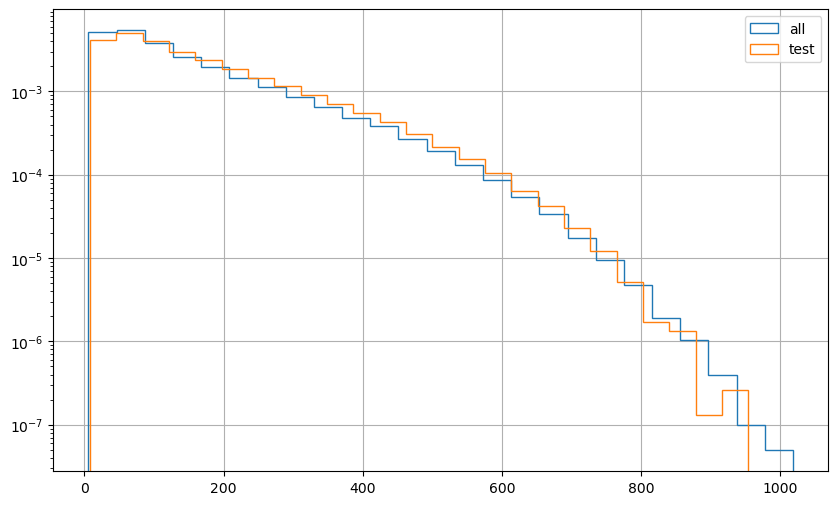

In [10]:
plt.figure(figsize=(10, 6))
# hist for number of items all users interacted with
grouped_by_user.size().hist(bins=25, log=True, density=True, histtype='step', label='all')
# hist for number of items test-users interacted with
train[train.user_id.isin(test.user_id)].groupby('user_id').size().hist(
    bins=25, log=True, density=True, histtype='step', label='test')
plt.legend()

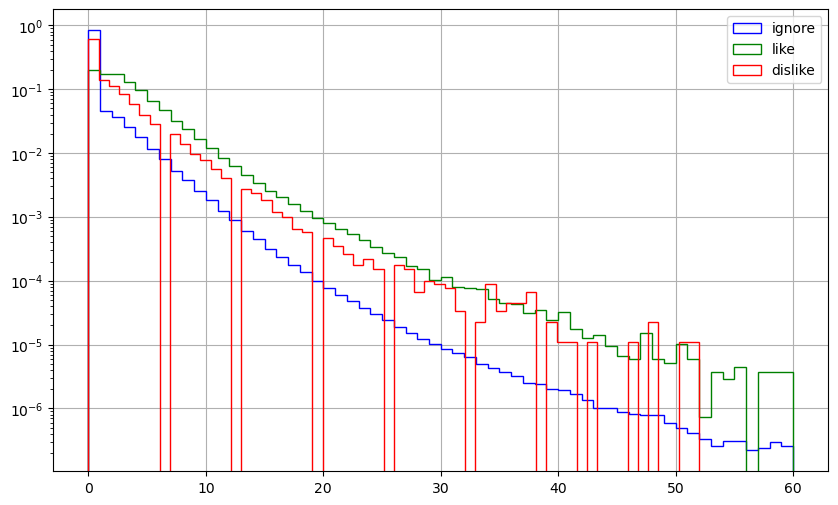

In [11]:
# Log timespent hist
plt.figure(figsize=(10, 6))
train.timespent.hist(bins=60, log=True, density=True, histtype='step', label='ignore', color='b')
train[train.reaction == 1].timespent.hist(bins=60, log=True, density=True, histtype='step', label='like', color='g')
train[train.reaction == -1].timespent.hist(bins=60, log=True, density=True, histtype='step', label='dislike', color='r')
plt.legend()

<BarContainer object of 3 artists>

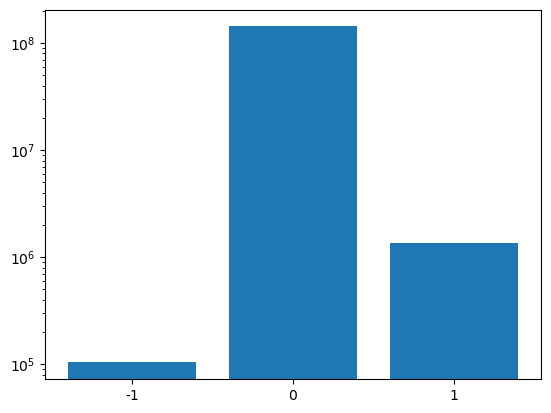

In [19]:
# Reaction log distribution
rtgs = train.reaction.value_counts()
plt.bar(x=rtgs.keys(), height=rtgs.values, tick_label=[0, 1, -1], log=True)

In [22]:
print(f"Repeatative interactions: {train.groupby(['user_id', 'item_id']).size().max() != 1}")

Repeatative interactions: False


In [28]:
# check if embeddings have the same shape
emb_sizes = items_meta.embeddings.apply(lambda emb: emb.shape).values
print(f"Unique shape of embeddings: {len(set(emb_sizes)) == 1}\n" + f"Embedding size: {emb_sizes[0][0]}")

Unique shape of embeddings: True
Embedding size: 312


## Extend post features

In [30]:
def items_stats(train_df):
    item_interactions = train_df.groupby('item_id').size()
    avg_interactions = item_interactions.mean()
    
    # check if users interacted with their own content
    self_interactions = pd.merge(
        items_meta,
        train_df,
        how="inner",
        left_on=['source_id', 'item_id'],
        right_on=['user_id', 'item_id']
    )
    self_interactions_ratio = len(self_interactions) / len(train_df)
    
    return item_interactions, avg_interactions, self_interactions, self_interactions_ratio

In [31]:
item_interactions, avg_interactions, self_interactions, self_interactions_ratio = items_stats(train)

In [37]:
print(f"Number of self-interactions: {len(self_interactions)}")

Number of self-interactions: 165


<AxesSubplot: >

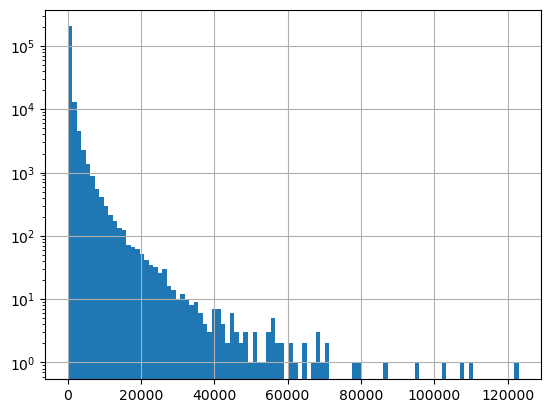

In [35]:
item_interactions.hist(log=True, bins=100)

In [39]:
# All posts present in train
common_item_ids = set(items_meta.item_id.to_list()).intersection(set(train.item_id.to_list()))
print(f"Every item is present in train samples: {len(common_item_ids) == len(items_meta)}")

Every item is present in train samples: True


<AxesSubplot: >

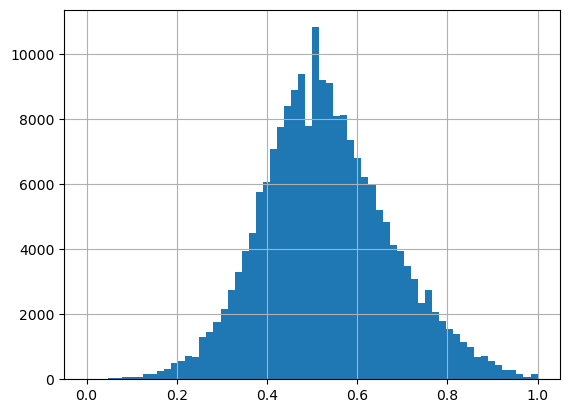

In [41]:
# Ratio of user activity applicable to test set
test_item_ids = set(candidates_df.item_id.tolist())
test_items_interactred_ratio = train[train.user_id.isin(test.user_id)].groupby('user_id').item_id.agg(
    lambda item_ids: len(set(item_ids).intersection(test_item_ids))/len(item_ids)
)
test_items_interactred_ratio.hist(bins=64)

## Visualize items embeddings

In [45]:
# Map to 2D
items = np.array(items_meta.embeddings.to_list())
reducer = umap.UMAP(verbose = True)
items_2d = reducer.fit_transform(items)

UMAP( verbose=True)
Fri Jan 20 16:35:58 2023 Construct fuzzy simplicial set
Fri Jan 20 16:35:58 2023 Finding Nearest Neighbors
Fri Jan 20 16:35:58 2023 Building RP forest with 29 trees
Fri Jan 20 16:36:02 2023 NN descent for 18 iterations
	 1  /  18
	 2  /  18
	 3  /  18
	 4  /  18
	 5  /  18
	Stopping threshold met -- exiting after 5 iterations
Fri Jan 20 16:36:12 2023 Finished Nearest Neighbor Search
Fri Jan 20 16:36:13 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Fri Jan 20 16:37:35 2023 Finished embedding


In [58]:
# Построить кластеризацию ембедингов
# Выделить на ней 
# (
#     Все посты самого активного юзера,                      ok
#     Все посты с большим охватом аудитории,                 ok    
#     Все посты с большим процентом лайков,                  ok
#     Все посты с большим временем просмотра                 ok
# )

In [51]:
items_stats = train.groupby('item_id').agg(
    avg_time  = pd.NamedAgg(column = 'timespent', aggfunc = 'mean'),
    users_cnt = pd.NamedAgg(column = 'user_id',   aggfunc = lambda x: len(set(x))),
    likes     = pd.NamedAgg(column = 'reaction',  aggfunc = lambda x: (x == 1).sum()),
    dislikes  = pd.NamedAgg(column = 'reaction',  aggfunc = lambda x: (x == -1).sum()),
    rating    = pd.NamedAgg(column = 'reaction',  aggfunc = lambda x: x.sum()/len(x))
)

In [52]:
items_stats

,avg_time,users_cnt,likes,dislikes,rating
item_id,,,,,
0,0.666667,15,2,0,0.133333
1,0.398168,1419,4,0,0.002819
2,1.578616,159,13,0,0.081761
3,0.300000,230,0,0,0.000000
4,0.214350,1115,1,0,0.000897
...,...,...,...,...,...
227601,0.183784,185,3,1,0.010811
227602,0.125000,96,1,0,0.010417
227603,0.160000,25,2,0,0.080000


In [53]:
# 100 most popular items
popuar_items = items_stats.nlargest(100, 'users_cnt')
popular_items_2d = items_2d[popuar_items.index.values]

# Gradient colors
max_users = popuar_items['users_cnt'].max()
popular_items_colors = (popuar_items['users_cnt'] / max_users).values

In [54]:
# 100 best rated items
rated_items = items_stats.nlargest(100, 'rating')
rated_items_2d = items_2d[rated_items.index.values]

# Gradient colors
max_rate = rated_items['rating'].max()
rated_items_colors = (rated_items['rating'] / max_rate).values

In [55]:
# 100 most time spent items
long_readed_items = items_stats.nlargest(100, 'avg_time')
long_readed_items_2d = items_2d[long_readed_items.index.values]

# Gradient colors
max_time = long_readed_items['avg_time'].max()
long_readed_items_colors = (long_readed_items['avg_time'] / max_time).values

In [60]:
most_active_user_id = users_stats.idxmax()
active_user_posts_2d = items_2d[train[train.user_id == most_active_user_id].item_id]

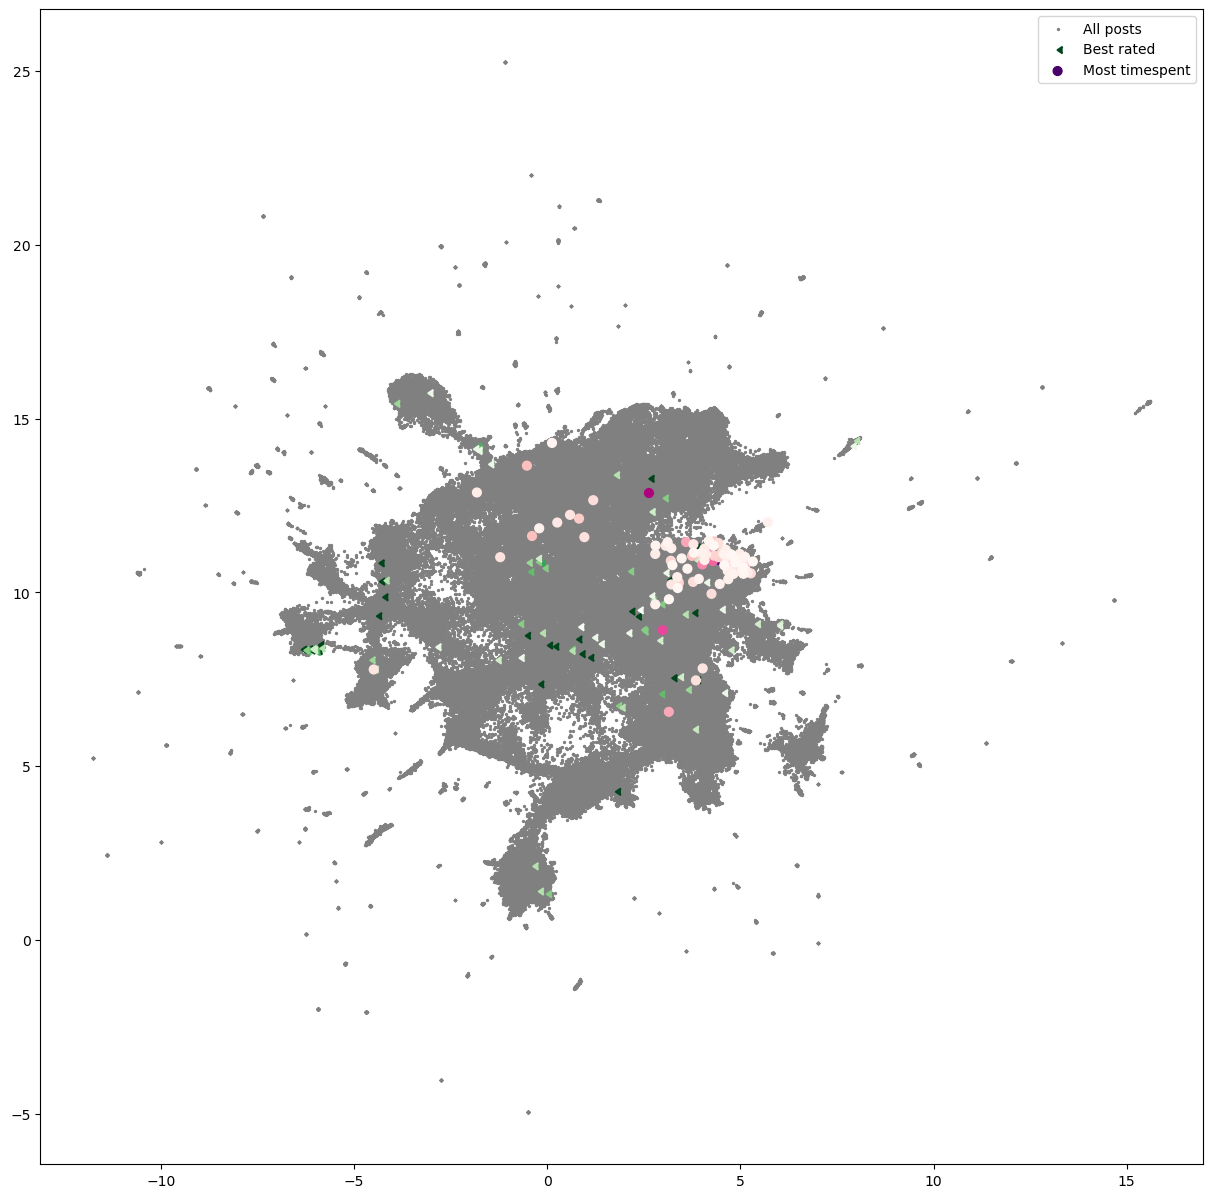

In [64]:
plt.figure(figsize=(15,15))
plt.scatter(items_2d[:,0], items_2d[:,1], 2, c='gray', label='All posts')
# plt.scatter(popular_items_2d[:, 0], popular_items_2d[:, 1], 24, 
#             c=popular_items_colors, cmap='Reds', label='Most viewed')
plt.scatter(rated_items_2d[:,0], rated_items_2d[:, 1], 24, 
            c=rated_items_colors, cmap='Greens', marker=4, label='Best rated')
plt.scatter(long_readed_items_2d[:,0], long_readed_items_2d[:, 1], 40, 
            c=long_readed_items_colors, cmap='RdPu', label='Most timespent')

# plt.scatter(active_user_posts_2d[:,0], active_user_posts_2d[:, 1], 8, c='y', alpha=0.5)

plt.legend()
plt.show()

In [65]:
embeddings = np.array(items_meta['embeddings'].tolist())
extended_embeddings = np.hstack([embeddings, items_stats[['avg_time', 'users_cnt', 'likes', 'dislikes']].values])
extended_embeddings.shape

(227606, 316)

<AxesSubplot: >

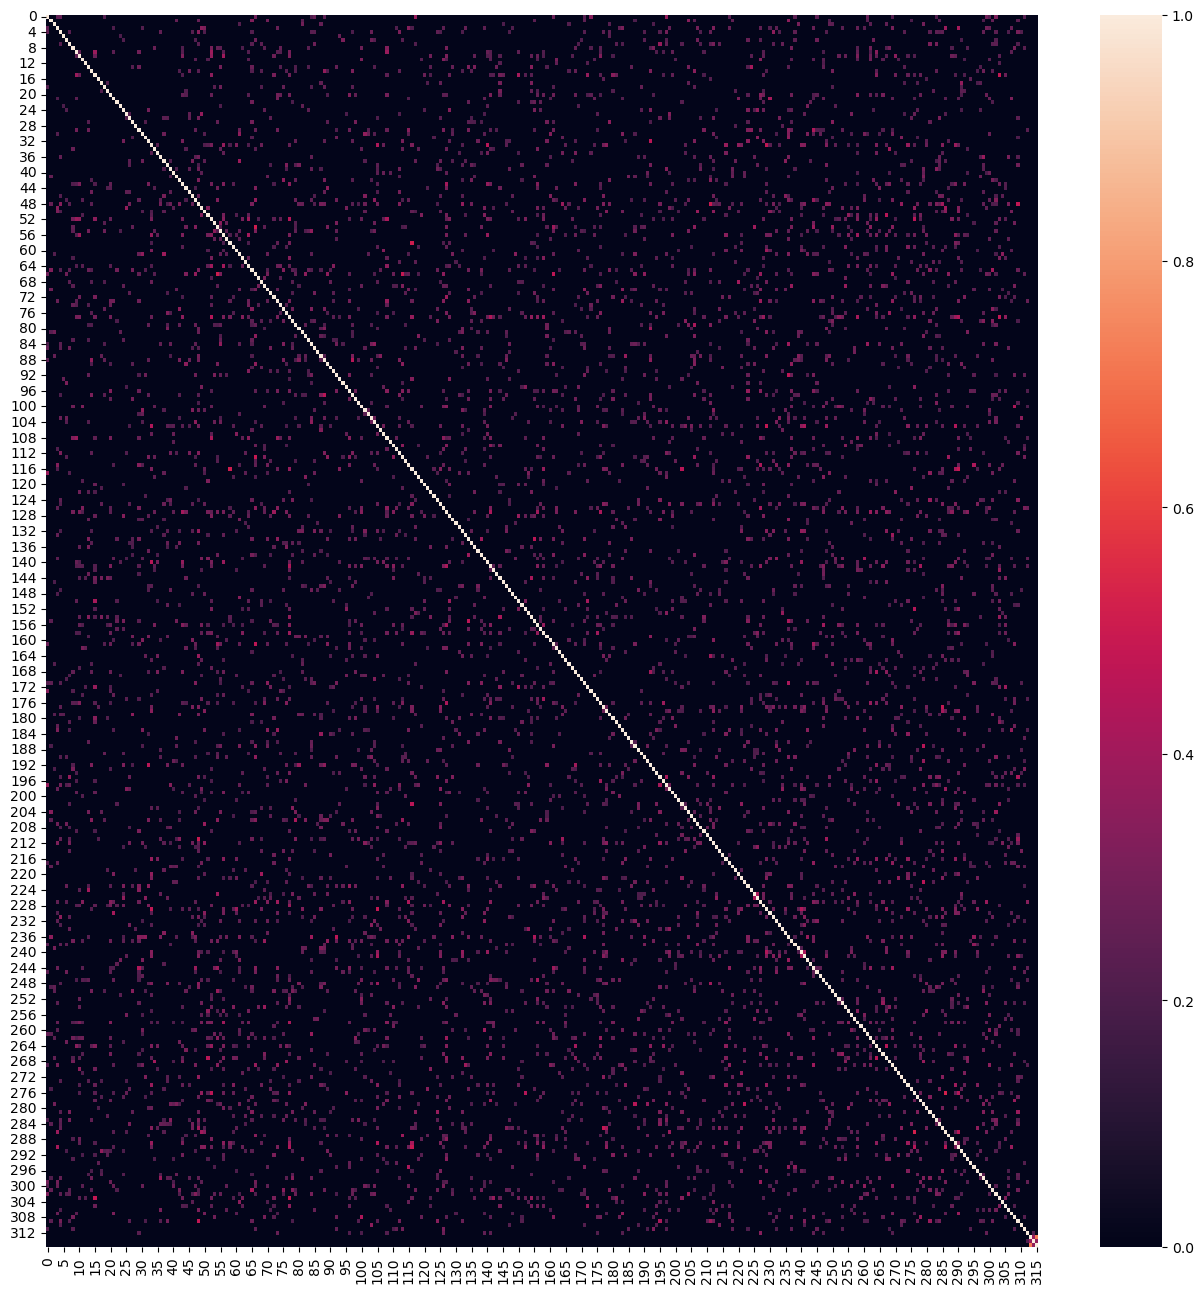

In [66]:
cor_m = np.corrcoef(extended_embeddings.T)
cor_m[cor_m < 0.2] = 0.
fig, ax = plt.subplots(figsize=(16,16))
sns.heatmap(cor_m, ax=ax)